# SOCS Project Script
This script creates a passenger and white-hat class which store attributes such as how likely an agent is to pay for a ticket etc. It stores all stops in a dictionary as keys and which passengers stay at each stop as items to the key. The model has been tested on a network with 100 nodes using 1000 passengers and 20 white-caps and runs smoothly and very fast.

**REMARK** This includes the possibility for adding random passengers, i.e passengers that do not have a work and a home.

In [1]:
import time, enum, math
import numpy as np
import pandas as pd
import pylab as plt
from tqdm.notebook import tqdm_notebook
import pickle

import networkx as nx
import random

from itertools import combinations, groupby
from scipy.stats import norm

import plotly.express as px
import seaborn as sns

from IPython.display import clear_output 
import matplotlib.font_manager

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

## Load data from Github
https://github.com/StyrbjornKall/SOCS_Project

In [3]:
# Get the data
!rm -r SOCS_Project
!git clone https://github.com/StyrbjornKall/SOCS_Project

rm: cannot remove 'SOCS_Project': No such file or directory
Cloning into 'SOCS_Project'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


In [4]:
home_work = pickle.load(open('/content/SOCS_Project/home_work_connections', 'rb'))
stop_connections = pickle.load(open('/content/SOCS_Project/stop_connections', 'rb'))
stop_pos = pickle.load(open('/content/SOCS_Project/stop_positions', 'rb'))

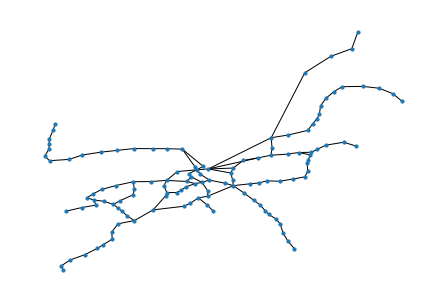

In [5]:
G  = nx.from_dict_of_dicts(stop_connections)
G.remove_edges_from(nx.selfloop_edges(G))
nx.draw(G, node_size=10, pos=stop_pos, with_labels=False, font_weight='normal')

## Define agent classes
`Passenger` is the passenger class. Symbolizes either a single individual but more likely a group of passengers.

`WhiteCaps`is the control agent class. Symbolizes a group of controllers traversing the network randomly. (The name comes from the fact that controllers on Vässtrafik carry white caps)

In [6]:
class Passenger:
  def __init__(self, id, ticket_price, init_slope, stop_connections, home_work_connections, p_random_passenger):
    self.RANDOM = np.random.choice([False,True], p=[1-p_random_passenger,p_random_passenger])
    self.path_id = np.random.randint(0,len(home_work_connections))
    self.path = home_work_connections[self.path_id]
    self.pos = self.path[0]

    self.id = id
    self.BUSTED = False
    self.ACTIVE = True

    # Add Cumulative distribution
    self.slope = -init_slope
    self.buy_prob = max(self.slope*ticket_price + 1,0)
    self.ticket = np.random.choice([False,True], p=[1-self.buy_prob,self.buy_prob])

# Add methods

  def MovePassenger(self):
    self.pos = self.path[self.path.index(self.pos)+1]

  def BuyTicket(self):
    self.ticket = np.random.choice([False,True], p=[1-self.buy_prob,self.buy_prob])

  def UpdateBuyProb(self, ticket_price, max_slope, min_slope):
    if self.BUSTED == True:
      if self.ticket == True:
        self.slope = self.slope*0.95
      else:
        self.slope = self.slope*0.99
    else:
      self.slope = self.slope*1.01

    if self.slope > -max_slope:
      self.slope = -max_slope
    elif self.slope < -min_slope:
      self.slope = -min_slope

    self.buy_prob = max(self.slope*ticket_price + 1,0)

  def ResetPassenger(self, home_work_connections):
    self.BUSTED = False
    self.ACTIVE = True

    if self.RANDOM == False:
      self.pos = self.path[0]
    else:
      self.path_id = np.random.randint(0,len(home_work_connections))
      self.path = home_work_connections[self.path_id]
      self.pos = self.path[0]

class WhiteCaps:
  def __init__(self, id, stop_connections):
    self.id = id
    self.pos = random.choice(list(stop_connections.keys()))

  def MoveWhiteCaps(self, stop_connections):
    self.pos = random.choice(list(stop_connections[self.pos]))
    


## Define Model class
`Model` is the actual simulation. Contains all set parameters and uses two main loops. 

`RunTrainingSimulation` Runs the training simulation.

`RunIncomeSimulation` Runs the simulation of daily income.

In [7]:
class Model:
  def __init__(self, npassengers, init_ticket_price, fine_price, stop_connections, home_work_connections, init_slope, max_slope, min_slope, nWc, p_random_passenger):
    # Initialize passengers
    self.npassengers = npassengers
    self.ticket_price = init_ticket_price
    self.fine_price = fine_price
    self.stop_connections = stop_connections
    self.home_work_connections = home_work_connections
    self.init_slope = init_slope
    self.max_slope = max_slope
    self.min_slope = min_slope
    self.p_random_passenger = p_random_passenger

    self.passenger_agents = []
    self.current_positions = {key:[] for key in stop_connections.keys()}
    for iagent in range(self.npassengers):
      pas = Passenger(iagent, self.ticket_price, self.init_slope, self.stop_connections, self.home_work_connections, self.p_random_passenger)
      self.passenger_agents.append(pas)
      self.current_positions[pas.pos].append(pas.id)

    # Initialize white-caps
    self.nWc = nWc
    self.white_cap_agents = []
    for iWC in range(self.nWc):
      cap = WhiteCaps(iWC, stop_connections)
      self.white_cap_agents.append(cap)

# Add methods for Model class
  def MovePassengers(self):
    self.current_positions = {key:[] for key in self.stop_connections.keys()}

    # Move every passenger
    for agent in self.passenger_agents:
      if agent.ACTIVE == True:
        Passenger.MovePassenger(agent)
        self.current_positions[agent.pos].append(agent.id)
      if agent.pos == agent.path[-1]:
        agent.ACTIVE = False

    for agent in self.white_cap_agents:
      WhiteCaps.MoveWhiteCaps(agent, self.stop_connections)

  def CheckControls(self):
    # Move WC and check if passenger on same station
    for agent in self.white_cap_agents:      
      if len(self.current_positions[agent.pos])>0:
          for passenger in self.current_positions[agent.pos]:
            if self.passenger_agents[passenger].BUSTED == False and self.passenger_agents[passenger].ACTIVE == True: 
              self.passenger_agents[passenger].BUSTED = True

  def RunTrainingSimulation(self, ndays, ntraverse):
    self.buy_counter = []
    self.passenger_history = np.zeros((ndays,self.npassengers))

    for iday in range(ndays):
      nbuy = 0
      # Un-bust every passenger
      for agent in self.passenger_agents:
        Passenger.ResetPassenger(agent, self.home_work_connections)

      for step in range(ntraverse):
        # Traverse edge
        self.MovePassengers()
          
        # Move WC and check if passenger on same station
        self.CheckControls()

      # Update parameters for passengers
      for iagent in range(len(self.passenger_agents)):
        agent = self.passenger_agents[iagent]
        agent.UpdateBuyProb(self.ticket_price, self.max_slope, self.min_slope)             # Update probability to buy ticket
        agent.BuyTicket()                                                                  # Buy ticket for day after
        if agent.ticket == True:
          nbuy += 1

        self.passenger_history[iday,iagent] = agent.buy_prob

      self.buy_counter.append(nbuy)

  def RunIncomeSimulation(self, ndays, ntraverse, ticket_price, fine_price, WC_cost):
    self.fine_price = fine_price
    self.ticket_price = ticket_price
    self.buy_counter = []
    self.busted_counter = []
    self.daily_income = []
    self.daily_cost = []

    for iday in range(ndays):
      nbuy = 0
      nbusted = 0

      for agent in self.passenger_agents:
        Passenger.ResetPassenger(agent, self.home_work_connections)

      for step in range(ntraverse):
        self.MovePassengers()
        self.CheckControls()

      for iagent in range(len(self.passenger_agents)):
        agent = self.passenger_agents[iagent]

        agent.BuyTicket()                             # Buy ticket for day after
        if agent.ticket == True:
          nbuy += 1
        elif agent.BUSTED == True:
          nbusted += 1

      self.buy_counter.append(nbuy)
      self.busted_counter.append(nbusted)
      self.daily_income.append(nbuy*self.ticket_price+nbusted*self.fine_price)
      self.daily_cost.append(self.nWc*WC_cost)


## Run one test simulation
Here we run the sim, loops over ndays and in each day every passenger and control agents traverse `ntraverse` nodes.

In [ ]:
npassengers = 1000
simulation_time = 50
ticket_price = 20
fine_price = 5000
max_stops = 14
init_slope = 1/(2*ticket_price)
max_slope = 1/1000
min_slope = 1/30
nWc = 0
p_random_passenger = 0

model_parameters = Model(npassengers, ticket_price, fine_price, stop_connections, home_work, init_slope, max_slope, min_slope, nWc, p_random_passenger)

In [ ]:
nWc_vector = [0,10,30]

results = []
for i in range(3):

  # Initialize white-caps
  model_parameters.nWc = nWc_vector[i]
  model_parameters.white_cap_agents = []
  for iWC in range(model_parameters.nWc):
    cap = WhiteCaps(iWC, stop_connections)
    model_parameters.white_cap_agents.append(cap)

  model_parameters.RunTrainingSimulation(ndays=simulation_time, ntraverse=max_stops)
  print(model_parameters.nWc)
  results.append(model_parameters.passenger_history)
  results.append(model_parameters.buy_counter)

0
10
30


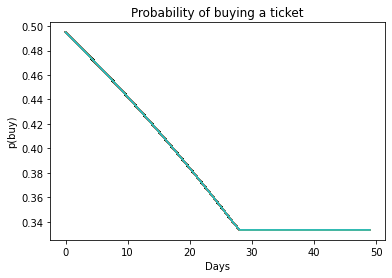

In [ ]:
plt.plot(range(simulation_time), results[0])


plt.title('Probability of buying a ticket')
plt.xlabel('Days')
plt.ylabel('p(buy)')
plt.show()

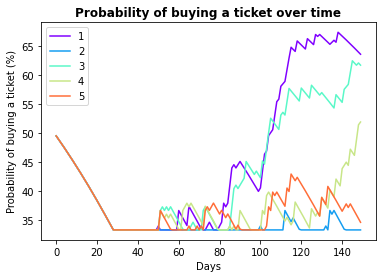

In [ ]:
probabilities = np.row_stack((results[0],results[2],results[4]))

labels = [1,2,3,4,5]
colors = plt.cm.rainbow(np.linspace(0, 3, 15))

for i in range(5):
  plt.plot(range(simulation_time*3), probabilities[:,15+i:16+i]*100, label=labels[i], c=colors[i])

plt.legend()
plt.title('Probability of buying a ticket over time', fontweight='bold')
plt.xlabel('Days')
plt.ylabel('Probability of buying a ticket (%)')
plt.show()

## Produce Heatmap
Here we generate the main results by running the simulation for a range of ticket prices and number of control agents. 

In [9]:
# Define parameters for simulation
max_ticket_price = 800
min_ticket_price = 25
max_nWC = 30
min_nWC = 0
WC_cost = 5000

npassengers = 2000
simulation_time = 50
fine_price = 500
max_stops = 14
p_random_passenger = 0.05

max_slope = 1/1000
min_slope = 1/50
income_days = 10

# Define range for ticket-price and number of control agents
number_of_WC_vector = np.arange(min_nWC,max_nWC,2)
ticket_price_vector = np.linspace(min_ticket_price,max_ticket_price,80)

# Define result arrays
heatmap = np.zeros((len(ticket_price_vector),len(number_of_WC_vector)))
nbusted = heatmap.copy()
nbought_tickets = heatmap.copy()

# Run main simulation
for i, nWc in enumerate(number_of_WC_vector):
  print('Simulating', nWc, 'white-caps')
  for j, ticket_price in enumerate(tqdm_notebook(ticket_price_vector)):
    init_slope = 1/(2*ticket_price)
    model_parameters = Model(npassengers, ticket_price, fine_price, stop_connections, home_work, init_slope, max_slope, min_slope, nWc, p_random_passenger)
    model_parameters.RunTrainingSimulation(ndays=simulation_time, ntraverse=max_stops)
  
    model_parameters.RunIncomeSimulation(income_days, max_stops, ticket_price, fine_price, WC_cost)
    heatmap[j,i] = np.mean(model_parameters.daily_income)-np.mean(model_parameters.daily_cost)
    nbought_tickets[j,i] = np.mean(model_parameters.buy_counter)
    nbusted[j,i] = np.mean(model_parameters.busted_counter)

  clear_output()


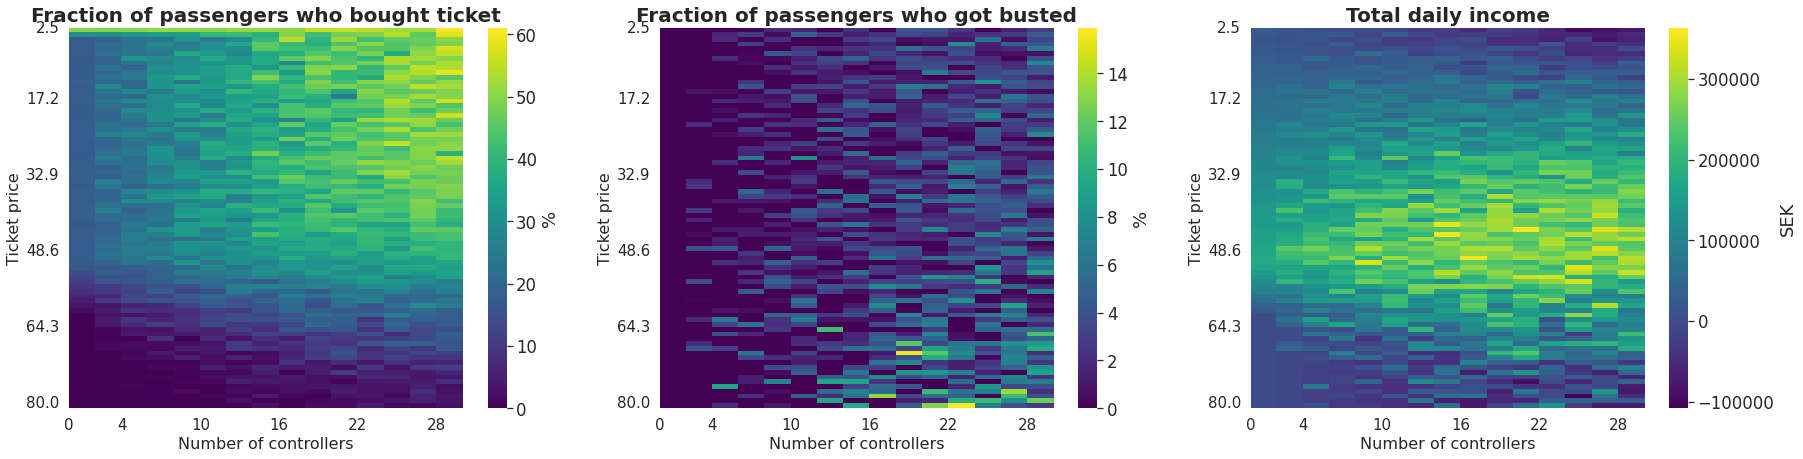

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(30,7))
num_ticks = 6
yticks = np.linspace(0, len(ticket_price_vector)-1, num_ticks, dtype=np.int)
yticklabels = [np.around(ticket_price_vector[idx])/10 for idx in yticks]
num_ticks = 6
xticks = np.linspace(0, len(number_of_WC_vector) - 1, num_ticks, dtype=np.int)
xticklabels = [np.around(number_of_WC_vector[idx]) for idx in xticks]

sns.heatmap(nbought_tickets/model_parameters.npassengers*100, ax=ax[0], xticklabels=xticklabels, yticklabels=yticklabels, cmap='viridis', cbar_kws={'label': '%'})

ax[0].set_yticks(yticks)
ax[0].set_xticks(xticks)
ax[0].set_title('Fraction of passengers who bought ticket', fontweight='bold', fontsize=20)
ax[0].set_xlabel('Number of controllers', fontsize=16)
ax[0].set_ylabel('Ticket price', fontsize=16)

sns.heatmap(nbusted/model_parameters.npassengers*100, ax=ax[1], xticklabels=xticklabels, yticklabels=yticklabels, cmap='viridis', cbar_kws={'label': '%'})

ax[1].set_yticks(yticks)
ax[1].set_xticks(xticks)
ax[1].set_title('Fraction of passengers who got caught', fontweight='bold', fontsize=20)
ax[1].set_xlabel('Number of controllers', fontsize=16)
ax[1].set_ylabel('Ticket price', fontsize=16)

sns.heatmap(heatmap, ax=ax[2], xticklabels=xticklabels, yticklabels=yticklabels, cmap='viridis', cbar_kws={'label': 'SEK'})
sns.set(font_scale=1.5)
ax[2].set_yticks(yticks)
ax[2].set_xticks(xticks)
ax[2].set_title('Total daily income', fontweight='bold', fontsize=20)
ax[2].set_xlabel('Number of controllers', fontsize=16)
ax[2].set_ylabel('Ticket price', fontsize=16)


ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[2].tick_params(axis='both', which='major', labelsize=15)

plt.show()

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(10,30))
num_ticks = 6
yticks = np.linspace(0, len(ticket_price_vector)-1, num_ticks, dtype=np.int)
yticklabels = [np.around(ticket_price_vector[idx])/10 for idx in yticks]
num_ticks = 6
xticks = np.linspace(0, len(number_of_WC_vector) - 1, num_ticks, dtype=np.int)
xticklabels = [np.around(number_of_WC_vector[idx]) for idx in xticks]

sns.heatmap(nbought_tickets/model_parameters.npassengers*100, ax=ax[0], xticklabels=xticklabels, yticklabels=yticklabels, cmap='viridis', cbar_kws={'label': '%'})

ax[0].set_yticks(yticks)
ax[0].set_xticks(xticks)
ax[0].set_title('Fraction of passengers who bought ticket', fontweight='bold', fontsize=20)
ax[0].set_xlabel('Number of controllers', fontsize=16)
ax[0].set_ylabel('Ticket price', fontsize=16)

sns.heatmap(nbusted/model_parameters.npassengers*100, ax=ax[1], xticklabels=xticklabels, yticklabels=yticklabels, cmap='viridis', cbar_kws={'label': '%'})

ax[1].set_yticks(yticks)
ax[1].set_xticks(xticks)
ax[1].set_title('Fraction of passengers who got caught', fontweight='bold', fontsize=20)
ax[1].set_xlabel('Number of controllers', fontsize=16)
ax[1].set_ylabel('Ticket price', fontsize=16)

sns.heatmap(heatmap, ax=ax[2], xticklabels=xticklabels, yticklabels=yticklabels, cmap='viridis', cbar_kws={'label': 'SEK'})
sns.set(font_scale=1.5)
ax[2].set_yticks(yticks)
ax[2].set_xticks(xticks)
ax[2].set_title('Total daily income', fontweight='bold', fontsize=20)
ax[2].set_xlabel('Number of controllers', fontsize=16)
ax[2].set_ylabel('Ticket price', fontsize=16)


ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[2].tick_params(axis='both', which='major', labelsize=15)


plt.show()

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(30,7))
num_ticks = 6
yticks = np.linspace(0, len(ticket_price_vector)-1, num_ticks, dtype=np.int)
yticklabels = [np.around(ticket_price_vector[idx]) for idx in yticks]
num_ticks = 6
xticks = np.linspace(0, len(number_of_WC_vector) - 1, num_ticks, dtype=np.int)
xticklabels = [np.around(number_of_WC_vector[idx]) for idx in xticks]

ax[0].plot(ticket_price_vector/10, nbought_tickets[:,10]/model_parameters.npassengers*100)
# ax[0].set_yticks(yticks)
# ax[0].set_xticks(xticks)
ax[0].set_title('Fraction of passengers who bought ticket', fontweight='bold', fontsize=15)
ax[0].set_xlabel('Ticket price (SEK)', fontsize=15)
ax[0].set_ylabel('Fraction of passengers (%)', fontsize=15)

ax[1].plot(ticket_price_vector/10, nbusted[:,10]/model_parameters.npassengers*100, color='orange')
# ax[1].set_yticks(yticks)
# ax[1].set_xticks(xticks)
ax[1].set_title('Fraction of passengers who got caught', fontweight='bold', fontsize=15)
ax[1].set_xlabel('Ticket price (SEK)', fontsize=15)
ax[1].set_ylabel('Fraction of passengers (%)', fontsize=15)

ax[2].plot(ticket_price_vector/10, heatmap[:,10]/1000)
# ax[2].set_yticks(yticks)
# ax[2].set_xticks(xticks)
ax[2].set_title('Total daily income', fontweight='bold', fontsize=15)
ax[2].set_xlabel('Ticket price (SEK)', fontsize=15)
ax[2].set_ylabel('Income (thousand SEK)', fontsize=15)


ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_ylim([-0.5, 10])
ax[2].tick_params(axis='both', which='major', labelsize=14)
ax[2].fill_between(ticket_price_vector/10, new/1000, alpha=0.4)
ax[2].fill_between(ticket_price_vector/10, new_bust/1000, alpha=0.4)

plt.show()

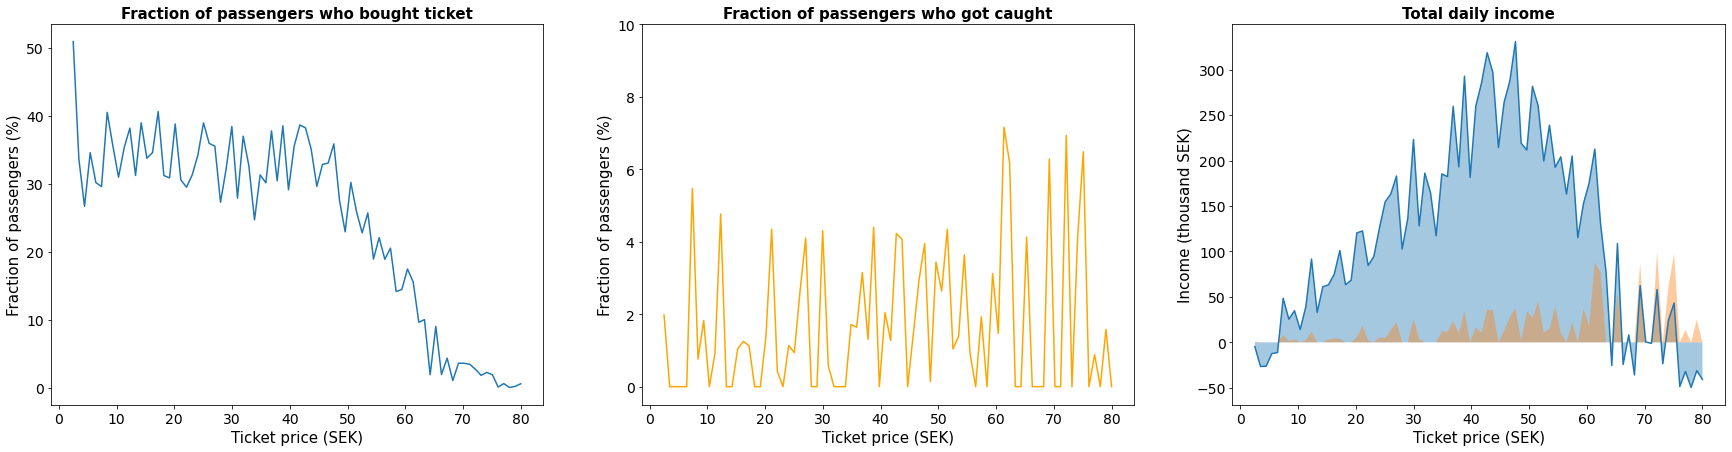

In [49]:
fig, ax = plt.subplots(1,3, figsize=(30,7))
num_ticks = 6
yticks = np.linspace(0, len(ticket_price_vector)-1, num_ticks, dtype=np.int)
yticklabels = [np.around(ticket_price_vector[idx]) for idx in yticks]
num_ticks = 6
xticks = np.linspace(0, len(number_of_WC_vector) - 1, num_ticks, dtype=np.int)
xticklabels = [np.around(number_of_WC_vector[idx]) for idx in xticks]

ax[0].plot(ticket_price_vector/10, nbought_tickets/model_parameters.npassengers*100)
# ax[0].set_yticks(yticks)
# ax[0].set_xticks(xticks)
ax[0].set_title('Fraction of passengers who bought ticket', fontweight='bold', fontsize=15)
ax[0].set_xlabel('Ticket price (SEK)', fontsize=15)
ax[0].set_ylabel('Fraction of passengers (%)', fontsize=15)

ax[1].plot(ticket_price_vector/10, nbusted/model_parameters.npassengers*100, color='orange')
# ax[1].set_yticks(yticks)
# ax[1].set_xticks(xticks)
ax[1].set_title('Fraction of passengers who got caught', fontweight='bold', fontsize=15)
ax[1].set_xlabel('Ticket price (SEK)', fontsize=15)
ax[1].set_ylabel('Fraction of passengers (%)', fontsize=15)

ax[2].plot(ticket_price_vector/10, heatmap/1000)
# ax[2].set_yticks(yticks)
# ax[2].set_xticks(xticks)
ax[2].set_title('Total daily income', fontweight='bold', fontsize=15)
ax[2].set_xlabel('Ticket price (SEK)', fontsize=15)
ax[2].set_ylabel('Income (thousand SEK)', fontsize=15)


ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_ylim([-0.5, 10])
ax[2].tick_params(axis='both', which='major', labelsize=14)
ax[2].fill_between(ticket_price_vector/10, new/1000, alpha=0.4)
ax[2].fill_between(ticket_price_vector/10, new_bust/1000, alpha=0.4)

plt.show()